In [15]:
import os
import pickle

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from config.settings import MCMC_DIR, PICS_DIR
from config.plotting import STD_colors

from scipy.integrate import cumulative_simpson
from scipy.stats import gaussian_kde

In [16]:
import matplotlib
matplotlib.__version__
plt.style.use('default')

In [17]:
filename="20250309_single31_1n_32w_10000st.pck"

with open(os.path.join(MCMC_DIR, filename), "rb") as file_open:
    data = pickle.load(file_open)

source, results = data[0], data[1]
op_SL_model, flat_samples = data[1][0], data[1][1]

In [18]:
alphas = np.sort(flat_samples[:, 0])
alpha2 = np.linspace(-1, 4, 1000)

pdf = gaussian_kde(alphas)(alpha2)

mean_i = np.argmax(pdf)
mean = alpha2[mean_i]

cdf = cumulative_simpson(pdf, x=alpha2)

quant_val = 0.9

left_quant_i = np.argmin(abs(cdf - (1 - quant_val)/2))
left_quant = alpha2[left_quant_i]
right_quant_i = np.argmin(abs(cdf - (1 + quant_val)/2))
right_quant = alpha2[right_quant_i]

print(mean - left_quant, right_quant - mean)

0.7357357357357355 0.47047047047047075


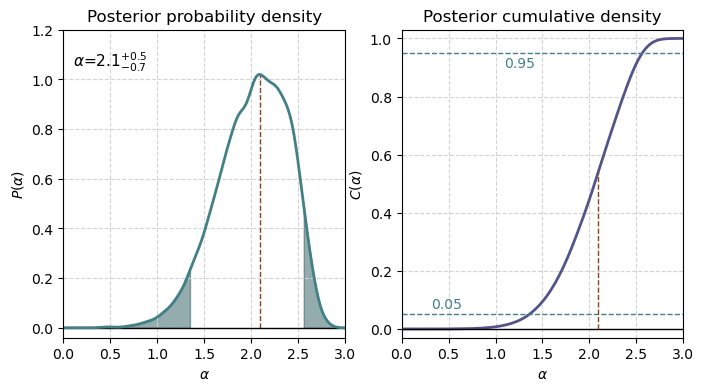

In [19]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Posterior probability density")
plt.fill_between(alpha2[:left_quant_i], np.zeros_like(alpha2[:left_quant_i]), pdf[:left_quant_i],
                 color=STD_colors[6], alpha=0.5)
plt.fill_between(alpha2[right_quant_i:], np.zeros_like(alpha2[right_quant_i::]), pdf[right_quant_i::],
                 color=STD_colors[6], alpha=0.5)
plt.plot((mean, mean), (0, pdf[mean_i]), linestyle='--', color=STD_colors[9], linewidth=1)
plt.text(0.1, 1.05, r"$\alpha$="f"{mean:.1f}"r"${}^{+0.5}_{-0.7}$", fontsize=11)

plt.plot((0, 3), (0, 0), linestyle='-', color='black', linewidth=1)

plt.plot(alpha2, pdf, color=STD_colors[0], linewidth=2)

plt.grid(linestyle='--', color="lightgrey")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$P(\alpha)$")
plt.xlim(0, 3)
plt.ylim(-0.04, 1.2)

plt.subplot(1, 2, 2)
plt.title("Posterior cumulative density")
plt.plot(alpha2[1:], cdf, color=STD_colors[1], linewidth=2)
plt.grid(linestyle='--', color="lightgrey")
plt.plot((0, 3), (0, 0), linestyle='-', color='black', linewidth=1)

plt.plot((0, 3), (0.05, 0.05), linestyle='--', color=STD_colors[0], linewidth=1)
plt.text(0.31, 0.07, "0.05", color=STD_colors[0])
plt.plot((0, 3), (0.95, 0.95), linestyle='--', color=STD_colors[0], linewidth=1)
plt.text(1.09, 0.9, "0.95", color=STD_colors[0])

plt.plot((mean, mean), (0, cdf[mean_i]), linestyle='--', color=STD_colors[9], linewidth=1)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$C(\alpha)$")
plt.xlim(0, 3)
plt.ylim(-0.03, 1.03)
# plt.tight_layout()

plt.savefig(os.path.join(PICS_DIR, "one_source_sl_analysis.pdf"))
plt.show()

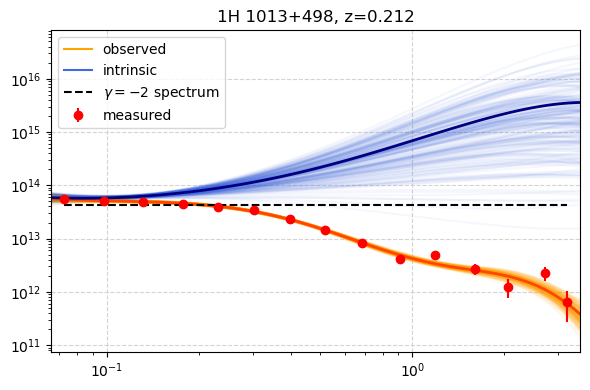

In [20]:
mod = 1.1
e1 = 10 ** np.linspace(np.log10(source.e_ref[0] / mod), np.log10(source.e_ref[-1] * mod), 100)

if_scale = True

scale = 1.0
if if_scale:
    scale = e1**2

xscale = 1e-12
e1_scaled = e1 * xscale

plt.figure(figsize=(6, 4))
obs_f, int_f = np.zeros([flat_samples.shape[0], e1.size]), np.zeros([flat_samples.shape[0], e1.size])
for i, s in enumerate(flat_samples):
    obs = op_SL_model.get(e1, s)
    s[0] = 0
    intrinsic = op_SL_model.get(e1, s)
    obs_f[i] = scale * obs
    int_f[i] = scale * intrinsic
    if i % 50 != 0:
        continue
    plt.plot(e1_scaled, obs_f[i], alpha=0.05, color="orange")
    plt.plot(e1_scaled, int_f[i], alpha=0.05, color="royalblue")

plt.plot(e1_scaled, np.mean(obs_f, axis=0), color="orangered", linewidth=2)
plt.plot(e1_scaled, np.mean(int_f, axis=0), color="navy", linewidth=2)
plt.plot((e1_scaled[0], e1_scaled[0]), (1e14, 1e14), color="orange", label='observed')
plt.plot((e1_scaled[0], e1_scaled[0]), (1e14, 1e14), color="royalblue", label='intrinsic')

plt.title(f"{source.title}, z={source.z}")
plt.grid(color='lightgray', linestyle='dashed')
source.plot_spectrum(if_show=False, if_scale=if_scale, ax=plt.gca(), xscale=xscale)
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(PICS_DIR, 'single_source_spectra.pdf'))
plt.show()